In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
import glob
import os
import re
import string
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
import pickle

# IMPORT DATA

In [190]:
# setting the path for joining multiple files with restaurant reviews
files = os.path.join("C:/Users/Elisaveta/Documents/ITMO/НИР/PROJECT/resturaunt_reviews/", "restaurant_*.csv")

# list of merged files returned
files = glob.glob(files)

# joining files with concat and read_csv
reviews_df = pd.concat(map(pd.read_csv, files), ignore_index=True)

In [191]:
reviews_df.head()

,restaurant,adress,name,date,review,rating
0,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Дмитрий Контраст,7 месяцев назад,"Первый раз в данном ресторане, сюда нас пригла...",5
1,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",полина никулина,7 месяцев назад,"Итак, в ресторане взяли «Зимний сет». Шеф и по...",3
2,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Maria ignatenko,11 месяцев назад,Очень атмосферное заведение. Шикарная подача б...,5
3,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Ekaterina Bagdasarova,год назад,Ваууууу. Других слов нет!\nРекомендую!\nНеверо...,5
4,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Роман Левин,год назад,"Были в этом ресторане уже дважды, планируем ещ...",5


In [193]:
reviews_df = reviews_df[~reviews_df['rating'].isin([7,8])]

In [194]:
ratings_mean_count = pd.DataFrame(reviews_df.groupby('restaurant')['rating'].mean().round(2))
ratings_mean_count['rating_counts'] = pd.DataFrame(reviews_df.groupby('restaurant')['rating'].count())
ratings_mean_count = ratings_mean_count.reset_index()

In [195]:
count_rating = reviews_df.groupby('rating')['restaurant'].count()
count_rating = count_rating.reset_index()

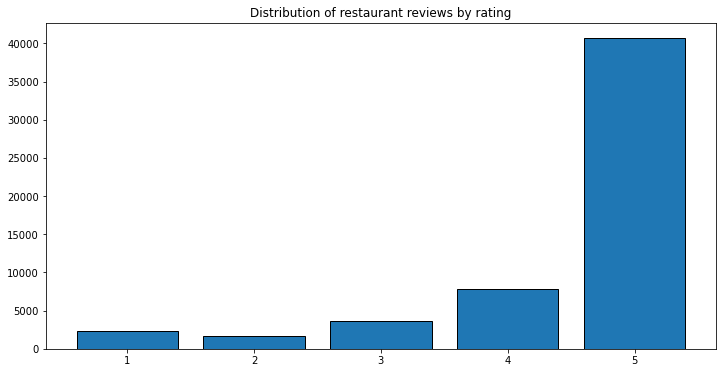

In [210]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.bar(rest_rating.rating, rest_rating.restaurant)


fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
plt.title('Distribution of restaurant reviews by rating')
plt.show()

In [197]:
import plotly.express as px

fig = px.box(ratings_mean_count, y=ratings_mean_count.rating_counts,title = "Box plot of number of restaurant reviews")
fig.show()

Text(0.5, 1.0, 'The histogram for average ratings')

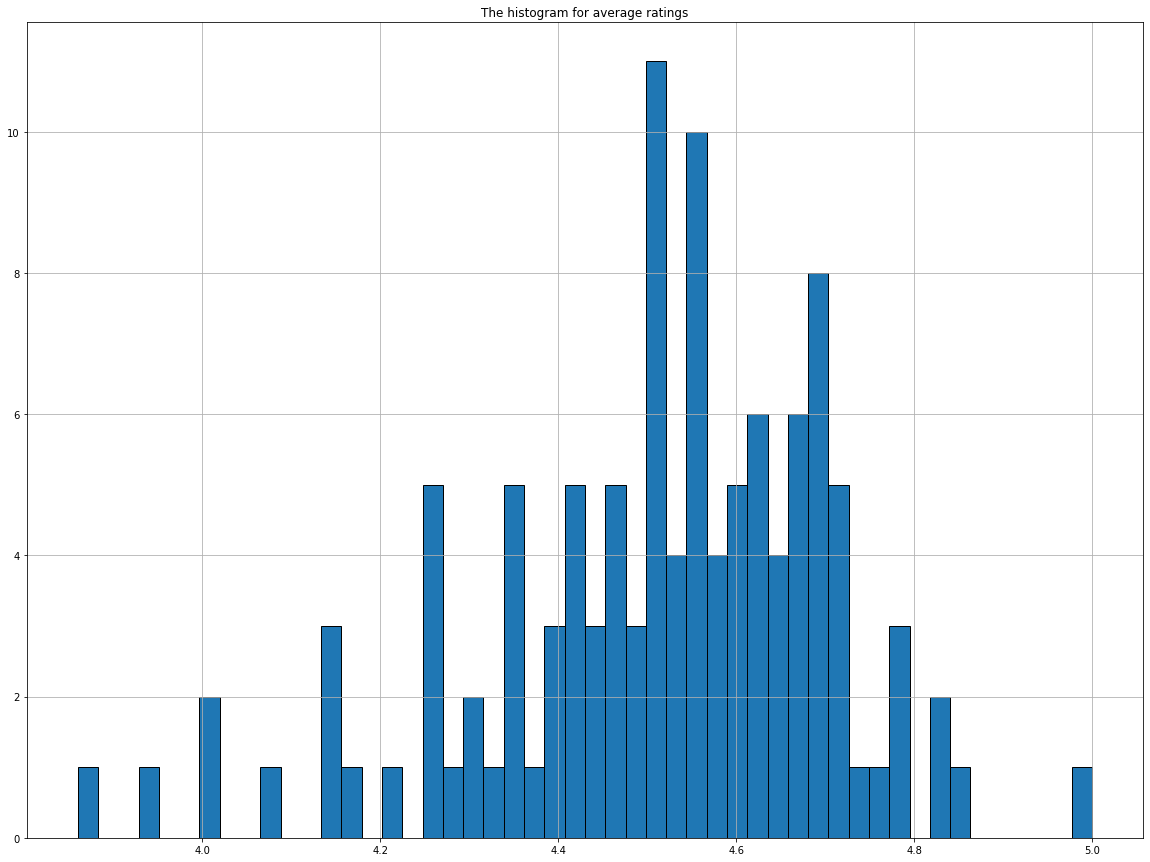

In [198]:
plt.figure(figsize=(20,15))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)
plt.title("The histogram for average ratings")

# PREPROCCESING DATA

In [199]:
#delete Nan values
reviews_df = reviews_df.dropna()

#find mean rating for each restaurant
ratings_dict = reviews_df.groupby('restaurant')['rating'].mean().round(2).to_dict()
reviews_df['mean_rating'] = reviews_df['restaurant'].map(ratings_dict)

In [200]:
reviews_df.head()

,restaurant,adress,name,date,review,rating,mean_rating
0,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Дмитрий Контраст,7 месяцев назад,"Первый раз в данном ресторане, сюда нас пригла...",5,4.67
1,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",полина никулина,7 месяцев назад,"Итак, в ресторане взяли «Зимний сет». Шеф и по...",3,4.67
2,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Maria ignatenko,11 месяцев назад,Очень атмосферное заведение. Шикарная подача б...,5,4.67
3,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Ekaterina Bagdasarova,год назад,Ваууууу. Других слов нет!\nРекомендую!\nНеверо...,5,4.67
4,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Роман Левин,год назад,"Были в этом ресторане уже дважды, планируем ещ...",5,4.67


In [201]:
#find stop words
stop = []
for word in stopwords.words('russian'):
    s = [char for char in word if char not in string.punctuation]
    stop.append(''.join(s))
    
for word in stopwords.words('english'):
    s = [char for char in word if char not in string.punctuation]
    stop.append(''.join(s))

In [202]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Lower Casing
    2. Remove all punctuation
    3. Remove all \n substrings
    4. Remove all URLs
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Lower Casing
    mess = mess.lower()
    
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation or char in '«»']
    
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    ## Removal of \n
    n_pattern = re.compile(r'\n')
    nopunc = n_pattern.sub(r' ', nopunc)
    
    ## Removal of URLS
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    nopunc = url_pattern.sub(r'', nopunc)
    
    # Now just remove any stopwords
    return " ".join([word for word in nopunc.split() if word not in stop])

#delete text before translating
def delete_original_text(mess):
    sub1 = "переведено google"
    sub2 = "оригинал"
    
    if sub1 in mess and sub2 not in mess:  
        return mess.split("переведено google")[1]
    elif sub1 in mess and sub2 in mess:        
        # getting index of substrings
        idx1 = mess.index(sub1)
        idx2 = mess.index(sub2)
        res = mess[idx1 + len(sub1) + 1: idx2]
        # length of substring 1 is added to
        # get string from next character
        return res
    else:
        return mess

In [203]:
#apply text_process and delete_original_text functions to review colummn in reviews_df
reviews_df['review'] = reviews_df['review'].apply(text_process)
reviews_df['review'] = reviews_df['review'].apply(delete_original_text)

In [204]:
reviews_df

,restaurant,adress,name,date,review,rating,mean_rating
0,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Дмитрий Контраст,7 месяцев назад,первый данном ресторане сюда пригласил олег га...,5,4.67
1,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",полина никулина,7 месяцев назад,итак ресторане взяли «зимний сет» шеф повара м...,3,4.67
2,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Maria ignatenko,11 месяцев назад,очень атмосферное заведение шикарная подача бл...,5,4.67
3,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Ekaterina Bagdasarova,год назад,ваууууу других слов рекомендую невероятная авт...,5,4.67
4,all Seasons,"Большая Морская ул., 34, Санкт-Петербург, Росс...",Роман Левин,год назад,ресторане дважды планируем ещё отличная кухня ...,5,4.67
...,...,...,...,...,...,...,...
75194,Ять,"наб. реки Мойки, 16, Санкт-Петербург, Россия, ...",PEDRO MARTINEZ,3 года назад,хорошая еда,4,4.46
75195,Ять,"наб. реки Мойки, 16, Санкт-Петербург, Россия, ...",Rachel Bailes,5 лет назад,попробуйте борщ,5,4.46
75196,Ять,"наб. реки Мойки, 16, Санкт-Петербург, Россия, ...",Berendina Van Straalen,4 года назад,прекрасная игра,4,4.46
75197,Ять,"наб. реки Мойки, 16, Санкт-Петербург, Россия, ...",Алла Шер,год назад,атмосферное,5,4.46


In [206]:
print('Number of user:', len(reviews_df.name.unique()))
print('Number of restaurants:', len(reviews_df.restaurant.unique()))
print('Number of review:', len(reviews_df))

Number of user: 43352
Number of restaurants: 116
Number of review: 56292


# LATENT FACTOR COLLABORATIVE FILTERING

## Data preparing 

In [86]:
#create user matrix
users_df = reviews_df[['name','review']]
#create restaurant matrix
restaurants_df = reviews_df[['restaurant', 'review']]

#join all reviews into one string for each users in user matrix
users_df = users_df.groupby('name').agg({'review': ' '.join})
#join all reviews into one string for each restaurant in restaurant matrix
restaurants_df = restaurants_df.groupby('restaurant').agg({'review': ' '.join})

In [87]:
users_df

,review
name,
# Jungman,приятное место цены выше среднего
# ТворюВолшебство,уютно атмосферно вежливые официанты ❤
### Yu li Ya ###,еда вкусная обслуживание хорошее душно
#RF_ ArtPhoto,высококлассный российский ресторан еда абсолют...
#brapmaster martin rotaryworkshop,место класс музяка советую
...,...
현림재,лучшая атмосфера дружелюбие персонала вкус хор...
현태훈,первый вкус свежего свежего типа очень
홍성식,атмосфера вкус еды хорошие доступность цена еды


In [88]:
restaurants_df

,review
restaurant,
Amo Cucinare,моему большому сожалению отзыв самый приятный ...
Barashki,отличное расположение повезёт забронировать ст...
Birch,друзья это великолепно интерьер персонал атмос...
Brisket Eat&Fun,отличное место жаль небольшое рассчитано небол...
Casa Del Мясо,отлично приятно аутентично сводчатый потолок к...
...,...
Щелкунчик,такс это столовая сразу скажу нужны тибон стей...
ЭТНОС,решили сводить родственников хорошее грузинско...
Эривань,замечательное место центре города прекрасным в...


In [89]:
#userid vectorizer
users_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=5000)
users_vectors = users_vectorizer.fit_transform(users_df['review'])
#Business id vectorizer
restaurants_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, max_features=5000)
restaurants_vectors = restaurants_vectorizer.fit_transform(restaurants_df['review'])

In [90]:
user_rating_matrix = pd.pivot_table(reviews_df, values='rating', index=['name'], columns=['restaurant'])

In [91]:
user_rating_matrix

restaurant,Amo Cucinare,Barashki,Birch,Brisket Eat&Fun,Casa Del Мясо,ChaCha,Del Mar,Duo,Duo Asia,EM,...,Фрегат Благодать,Хачапури и вино,Чуфальня,Шеф-Маруся и ко,Штакеншнейдер,Щелкунчик,ЭТНОС,Эривань,Юми,Ять
name,,,,,,,,,,,,,,,,,,,,,
# Jungman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
# ТворюВолшебство,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
### Yu li Ya ###,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#RF_ ArtPhoto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
#brapmaster martin rotaryworkshop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
현림재,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
현태훈,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
홍성식,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
P = pd.DataFrame(users_vectors.toarray(), index=users_df.index, columns=users_vectorizer.get_feature_names())
Q = pd.DataFrame(restaurants_vectors.toarray(), index=restaurants_df.index, columns=restaurants_vectorizer.get_feature_names())

## Matrix factorization

In [93]:
def matrix_factorization(R, P, Q, steps=25, gamma=0.001,lamda=0.02):
    for step in range(steps):
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    eij=R.loc[i,j]-np.dot(P.loc[i],Q.loc[j])
                    P.loc[i]=P.loc[i]+gamma*(eij*Q.loc[j]-lamda*P.loc[i])
                    Q.loc[j]=Q.loc[j]+gamma*(eij*P.loc[i]-lamda*Q.loc[j])
        e=0
        for i in R.index:
            for j in R.columns:
                if R.loc[i,j]>0:
                    e= e + pow(R.loc[i,j]-np.dot(P.loc[i],Q.loc[j]),2)+lamda*(pow(np.linalg.norm(P.loc[i]),2)+pow(np.linalg.norm(Q.loc[j]),2))
        if e<0.001:
            break
        
    return P,Q

In [94]:
P, Q = matrix_factorization(user_rating_matrix, P, Q, steps=25, gamma=0.001,lamda=0.02)

In [95]:
Q.to_csv('Q.csv')

In [96]:
P.to_csv('P.csv')

## Export model

In [72]:
Q = pd.read_csv('./Q.csv')

In [73]:
P = pd.read_csv('./P.csv')

In [98]:
# Store P, Q and vectorizer in pickle file
output = open('recommendation_users_vectorizer.pkl', 'wb')
pickle.dump(users_vectorizer,output)
output.close()

In [99]:
# Store P, Q and vectorizer in pickle file
output = open('recommendation_reviews_df.pkl', 'wb')
pickle.dump(reviews_df,output)
output.close()

In [100]:
# Store P, Q and vectorizer in pickle file
output = open('recommendation_P.pkl', 'wb')
pickle.dump(P,output)
output.close()

In [101]:
# Store P, Q and vectorizer in pickle file
output = open('recommendation_Q.pkl', 'wb')
pickle.dump(Q,output)
output.close()

## Testing model

In [114]:
def recommender_collaborative_filtering(response,Q):
    test_df= pd.DataFrame([response], columns=['text'])
    test_df['text'] = test_df['text'].apply(text_process)
    test_vectors = users_vectorizer.transform(test_df['text'])
    test_v_df = pd.DataFrame(test_vectors.toarray(), index=test_df.index, columns=users_vectorizer.get_feature_names())
    predictItemRating=pd.DataFrame(np.dot(test_v_df.loc[0],Q.T),index=Q.index,columns=['Rating'])
    topRecommendations=pd.DataFrame.sort_values(predictItemRating,['Rating'],ascending=[0])[:7]
    
    print('ПО ЗАПРОСУ "%s" РЕКОМЕНДОВАНЫ СЛЕДУЮЩИЕ РЕСТОРАНЫ: ' % response.upper())
    
    for i in topRecommendations.index:
        print(reviews_df[reviews_df['restaurant']==i]['restaurant'].iloc[0])
        print("Рейтинг", reviews_df[reviews_df['restaurant']==i]['mean_rating'].iloc[0],"из 5")
        print(reviews_df[reviews_df['restaurant']==i]['adress'].iloc[0])
        print('')

In [115]:
recommender_collaborative_filtering('ресторан на крыше',Q)

ПО ЗАПРОСУ "РЕСТОРАН НА КРЫШЕ" РЕКОМЕНДОВАНЫ СЛЕДУЮЩИЕ РЕСТОРАНЫ: 
Гастрономика
Рейтинг 4.13 из 5
ул. Марата, 5/21, Санкт-Петербург, Россия, 191025

Sadko
Рейтинг 4.39 из 5
ул. Глинки, 2, Санкт-Петербург, Россия, 190068

Вино и Вода
Рейтинг 4.61 из 5
ул. Чайковского, 17, Санкт-Петербург, Россия, 191187

Ресторан Баку
Рейтинг 4.29 из 5
Садовая ул., 12, Санкт-Петербург, Россия, 191011

Большая Кухня
Рейтинг 4.31 из 5
Лиговский пр., 30А, Санкт-Петербург, Россия, 191040

Летучий Голландец
Рейтинг 4.36 из 5
 Невский пр., 88, Санкт-Петербург, Россия, 191025

Ресторан Ферма на финляндском (Доставка)
Рейтинг 4.68 из 5
Финляндский пр., 1, Санкт-Петербург, Россия, 194044



In [116]:
recommender_collaborative_filtering('ресторан грузинской кухни',Q)

ПО ЗАПРОСУ "РЕСТОРАН ГРУЗИНСКОЙ КУХНИ" РЕКОМЕНДОВАНЫ СЛЕДУЮЩИЕ РЕСТОРАНЫ: 
Сакартвело
Рейтинг 4.7 из 5
12-я лин. В.О., 13, Санкт-Петербург, Россия, 199178

ChaCha
Рейтинг 4.51 из 5
наб. канала Грибоедова, 8/1, Санкт-Петербург, Россия, 191011

Rustaveli
Рейтинг 4.47 из 5
наб. реки Мойки, 9, Санкт-Петербург, Россия, 191186

Грузинское кафе Сулико грузинская кухня с доставкой
Рейтинг 4.54 из 5
ул. Восстания, 7, Санкт-Петербург, Россия, 191036

Тбилисити
Рейтинг 4.67 из 5
Литейный пр., дом 10, Санкт-Петербург, Россия, 191028

Тархун
Рейтинг 4.47 из 5
Караванная ул., 14, Санкт-Петербург, Россия, 191023

Sadko
Рейтинг 4.39 из 5
ул. Глинки, 2, Санкт-Петербург, Россия, 190068



In [118]:
recommender_collaborative_filtering('вкусная пицца',Q)

ПО ЗАПРОСУ "ВКУСНАЯ ПИЦЦА" РЕКОМЕНДОВАНЫ СЛЕДУЮЩИЕ РЕСТОРАНЫ: 
Villaggio
Рейтинг 4.26 из 5
Тучков пер., 11/5, Санкт-Петербург, Россия, 199004

Italy
Рейтинг 4.43 из 5
Большая Морская ул., 14, Санкт-Петербург, Россия, 190000

Марчеллис
Рейтинг 4.49 из 5
Невский пр., 21, Санкт-Петербург, Россия, 191187

Little Sicily
Рейтинг 4.79 из 5
ул. Марата, 13, Санкт-Петербург, Россия, 191025

Jerome
Рейтинг 4.48 из 5
Большая Морская ул., 25, Санкт-Петербург, Россия, 190000

Мама на даче
Рейтинг 4.16 из 5
Невский пр., 88, Санкт-Петербург, Россия, 191025

Большая Кухня
Рейтинг 4.31 из 5
Лиговский пр., 30А, Санкт-Петербург, Россия, 191040



# CONTENT BASE RECOMMENDER SYSTEM

## Data preparing

In [129]:
cb_restaurants_df = reviews_df[['restaurant', 'review']]
#join all reviews of restaurant into one string
cb_restaurants_df = cb_restaurants_df.groupby('restaurant',as_index=False).agg({'review': ' '.join})

In [130]:
#create dictionary with restaurants mean rating 
mean_rating_dict = reviews_df.groupby('restaurant')['rating'].mean().round(2).to_dict()
#create dictionary with restaurants address
address_arr = np.array(reviews_df[['restaurant','adress']].drop_duplicates().reset_index(drop=True))
address_dict={}
for addr in address_arr:
    address_dict[str(addr[0])] = addr[1]

In [131]:
cb_restaurants_df['mean_rating'] = cb_restaurants_df['restaurant'].map(mean_rating_dict)
cb_restaurants_df['address']     = cb_restaurants_df['restaurant'].map(address_dict)

In [132]:
cb_restaurants_df.head()

,restaurant,review,mean_rating,address
0,Amo Cucinare,моему большому сожалению отзыв самый приятный ...,4.44,"Большая Конюшенная ул., 5, Санкт-Петербург, Ро..."
1,Barashki,отличное расположение повезёт забронировать ст...,3.94,"ул. Ефимова, 2, Санкт-Петербург, Россия, 190031"
2,Birch,друзья это великолепно интерьер персонал атмос...,4.67,"Кирочная ул., дом 3, Санкт-Петербург, Россия, ..."
3,Brisket Eat&Fun,отличное место жаль небольшое рассчитано небол...,4.64,"Шведский пер., 2, Санкт-Петербург, Россия, 191186"
4,Casa Del Мясо,отлично приятно аутентично сводчатый потолок к...,4.48,"Биржевой пр-д, д.6, Санкт-Петербург, Россия, 1..."


In [133]:
#Changing data set index by restaurant name
cb_restaurants_df.set_index('restaurant', inplace=True)

##  Word Frequency Distribution

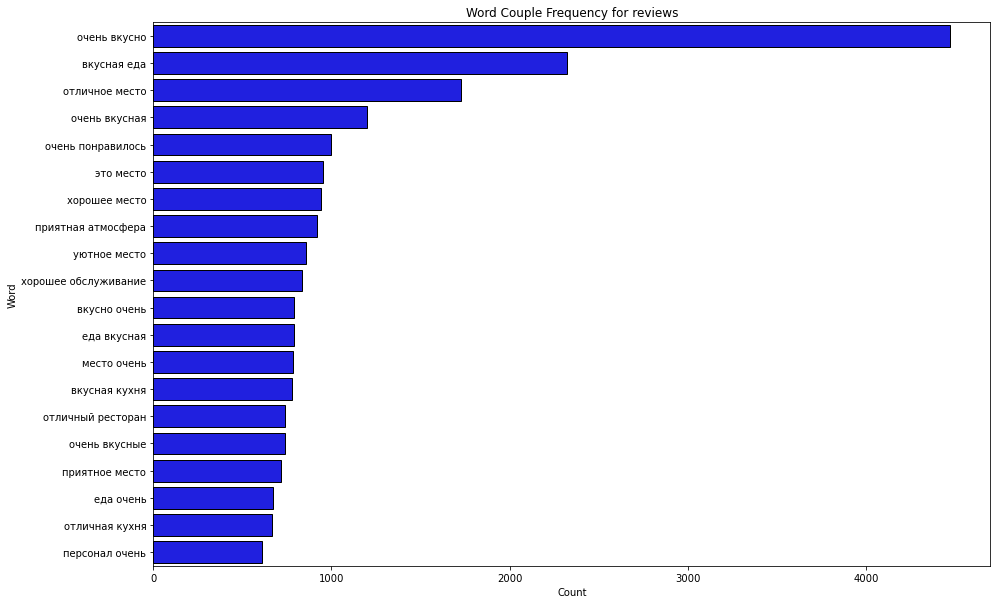

In [134]:
#Word Frequency Distribution
def get_top_words(column, top_nu_of_words, nu_of_word):    
    vec = CountVectorizer(ngram_range= nu_of_word)
    bag_of_words = vec.fit_transform(column)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_nu_of_words]

#Top 20 two word frequencies for Restaurants
list1 = get_top_words(cb_restaurants_df['review'], 20, (2,2))

df_words1 = pd.DataFrame(list1, columns=['Word', 'Count'])

plt.figure(figsize=(15,10))
sns.barplot(data=df_words1, x='Count', y='Word',color = 'blue')
plt.title('Word Couple Frequency for reviews');

## TF-IDF method

In [135]:
# Saving indexes in a series
indices = pd.Series(cb_restaurants_df.index)

# Creating tf-idf matrix
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(cb_restaurants_df['review'])

# Calculating cosine similarities
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

## Content-based recommender system using correlation 

In [211]:
ratings_mean_count = ratings_mean_count.set_index('restaurant')

In [252]:
def recommender_content_based_correlation(name,user_rating_matrix, ratings_mean_count,num):
    rest = user_rating_matrix[name]
    rest_like_name = user_rating_matrix.corrwith(rest)
    corr_rest = pd.DataFrame(rest_like_name, columns=['Correlation'])
    corr_rest.dropna(inplace=True)
    corr_rest = corr_rest.join(ratings_mean_count['rating_counts'])
    corr_rest = corr_rest[corr_rest ['rating_counts']>100].sort_values('Correlation', ascending=False)
    corr_rest = corr_rest.join(cb_restaurants_df['mean_rating'])
    corr_rest = corr_rest.join(cb_restaurants_df['address'])
    print('Top %s restaurants like %s with similar reviews finding using correlation: ' % (num, name))
    #corr_rest = corr_rest.reset_index()
    return corr_rest[['mean_rating','address']]

In [253]:
recommender_content_based_correlation('Amo Cucinare',user_rating_matrix, ratings_mean_count,10).head(10)

C:\Users\Elisaveta\anaconda3\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\Elisaveta\anaconda3\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning:

divide by zero encountered in true_divide



Top 10 restaurants like Amo Cucinare with similar reviews finding using correlation: 


,mean_rating,address
restaurant,,
Amo Cucinare,4.44,"Большая Конюшенная ул., 5, Санкт-Петербург, Ро..."
Duo,4.59,"Кирочная ул., 8А, Санкт-Петербург, Россия, 191028"
Volga-Volga,4.56,Санкт-Петербург Петровская набережная 8 спуск ...
Юми,4.51,"Разъезжая ул., 10/15, 1 этаж, Санкт-Петербург,..."
Мари Vаnnа,4.70,"Мытнинская наб., 3, Санкт-Петербург, Россия, 1..."
Счастье,4.35,"ул. Рубинштейна, 15-17, Санкт-Петербург, Росси..."
Греческая таверна Сиртаки,4.41,"Невский пр., 102, 2 этаж, Санкт-Петербург, Рос..."
Сулико,4.60,"Казанская ул., 6, Санкт-Петербург, Россия, 190000"
Jerome,4.48,"Большая Морская ул., 25, Санкт-Петербург, Росс..."


## Content-based recommender system using cosinus similarities 

In [242]:
def recommender_content_based_cosine_similarities(name, cosine_similarities = cosine_similarities):
    # Create a list to put top 10 restaurants
    recommend_restaurant = []
    # Find the index of the restaurant entered
    idx = indices[indices == name].index[0]
    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)    
    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)
    
    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(cb_restaurants_df.index)[each])    
    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=[ 'mean_rating', 'address'])
    
    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(cb_restaurants_df[['mean_rating','address']][cb_restaurants_df.index == each].sample()))
    
    
    df_new = df_new.drop([name])
    # Drop the same named restaurants and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['mean_rating','address'], keep=False)
    df_new = df_new.sort_values(by='mean_rating', ascending=False).head(10)
    
    print('Top %s restaurants like %s with similar reviews using cosine similarities: ' % (str(len(df_new)), name))
    
    return df_new

In [243]:
recommender_content_based_cosine_similarities('Amo Cucinare')

Top 10 restaurants like Amo Cucinare with similar reviews using cosine similarities: 


,mean_rating,address
Schengen,4.73,"Кирочная ул., 5, Санкт-Петербург, Россия, 191028"
Банщики,4.71,"Дегтярная ул., 1А, Санкт-Петербург, Россия, 19..."
Harvest,4.70,"пр. Добролюбова, 11, Санкт-Петербург, Россия, ..."
Serbish,4.69,"ул. Пестеля, 8/36, Санкт-Петербург, Россия, 19..."
Ресторан Ферма на финляндском (Доставка),4.68,"Финляндский пр., 1, Санкт-Петербург, Россия, 1..."
Северянин,4.68,"Столярный пер., 18/69, Санкт-Петербург, Россия..."
ЭТНОС,4.65,"Кузнечный пер., 8, Санкт-Петербург, Россия, 19..."
Гости,4.61,"Малая Морская ул., 13, Санкт-Петербург, Россия..."
Duo Asia,4.61,"ул. Рубинштейна, 20, Санкт-Петербург, Россия, ..."
Сулико,4.60,"Казанская ул., 6, Санкт-Петербург, Россия, 190000"
